# iNaturalist data

[iNaturalist](https://inaturalist.org) is a platform that records observations of living organisms, annotated with their locations and taxonomic identifications. We will be considering data for plants here.  This notebook illustrates some methods of [large scale inference](https://efron.ckirby.su.domains/other/2010LSIexcerpt.pdf) that can be used to identify systematic changes in species locations over time. 

In [38]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pathlib import Path
import cartopy.crs as ccrs
from scipy.stats.distributions import norm, chi2
from scipy.stats.distributions import t as tdist
from statsmodels.stats.multitest import local_fdr
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

Below we select a [class](https://en.wikipedia.org/wiki/Class_(biology)) of species to analyze.  A class is a taxonomic grouping that includes many species.  [Pinopsida](https://en.wikipedia.org/wiki/Conifer) are conifers and [polypodiopsida](https://en.wikipedia.org/wiki/Fern) are ferns.

In [39]:
#pclass = "Pinopsida"
pclass = "Polypodiopsida"

The data are located at this path:

In [40]:
pa = Path("/home/kshedden/data/Teaching/inaturalist")

In [41]:
fn = pa / ("Plantae_%s.csv.gz" % pclass)

Below we load the data and show what it looks like.

In [42]:
df = pd.read_csv(fn, parse_dates=["eventDate"])
print(df.shape)
df.head()

(965793, 5)


,species,decimalLatitude,decimalLongitude,elevation,eventDate
0,Amauropelta noveboracensis,41.648238,-72.278863,NaN,2016-05-28 15:12:00
1,Sceptridium dissectum,35.826566,-80.009607,NaN,2016-08-12 17:13:00
2,Schizaea pectinata,-34.014999,19.706271,NaN,2011-08-14 21:42:00
3,Myriopteris covillei,32.209233,-110.534942,NaN,2017-08-06 14:26:58
4,Dryopteris marginalis,42.374007,-76.876130,NaN,2018-03-20 14:18:00


The dates are mostly in the past 8 years, but a few dates are much older than that.  We will analyze observations made since 2015.

In [43]:
df = df.query("eventDate >= 20150101")

Next we construct a time variable that starts on January 1, 2015 and counts in 1000's of days from that origin.  We will be interested in the evidence that for specific species, the average latitude changes linearly as a function of this 'day' variable. 

In [44]:
df["day"] = (df["eventDate"] - pd.to_datetime("2015-01-01")).dt.days
df["day"] /= 1000

This is the total number of observations (the number of plant occurrences in the dataset for the selected class of species):

In [45]:
df.shape

(936317, 6)

The next cell calculates the number of distinct species.

In [46]:
df["species"].value_counts().size

3060

Below we make a histogram of the number of observations per species.

Text(0, 0.5, 'Frequency')

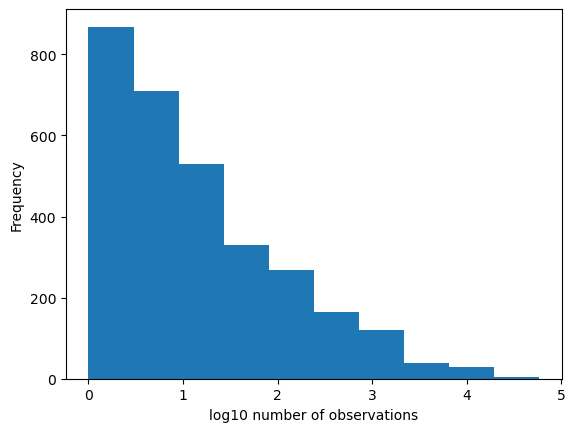

In [47]:
nn = df.groupby("species").size()
plt.hist(np.log10(nn))
plt.xlabel("log10 number of observations")
plt.ylabel("Frequency")

A quantile plot is usually more informative than a histogram.

Text(0, 0.5, 'log10 number of observations')

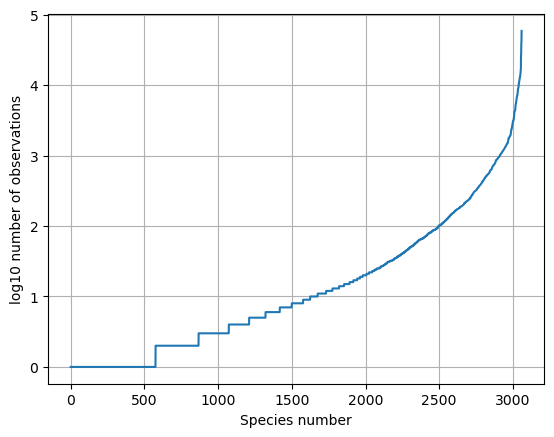

In [48]:
plt.clf()
plt.grid(True)
plt.plot(np.sort(np.log10(nn)))
plt.xlabel("Species number")
plt.ylabel("log10 number of observations")

In [49]:
df.head()

,species,decimalLatitude,decimalLongitude,elevation,eventDate,day
0,Amauropelta noveboracensis,41.648238,-72.278863,NaN,2016-05-28 15:12:00,0.513
1,Sceptridium dissectum,35.826566,-80.009607,NaN,2016-08-12 17:13:00,0.589
3,Myriopteris covillei,32.209233,-110.534942,NaN,2017-08-06 14:26:58,0.948
4,Dryopteris marginalis,42.374007,-76.876130,NaN,2018-03-20 14:18:00,1.174
5,Osmundastrum cinnamomeum,46.614966,-84.474779,NaN,2018-06-13 18:01:39,1.259


Make a plot showing the distribution of the occurences (the locations where a plant was observed).

<Figure size 640x480 with 0 Axes>

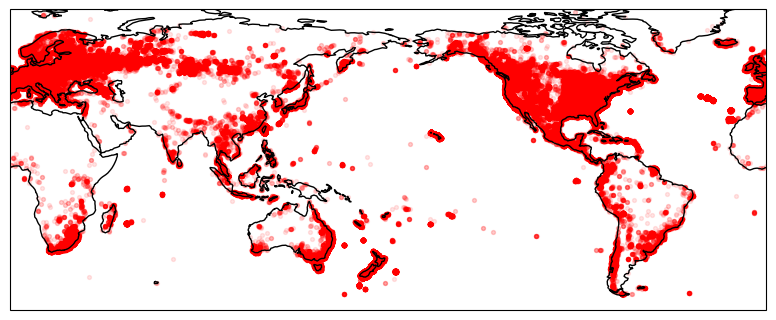

In [50]:
plt.clf()
plt.figure(figsize=(9, 7.25))
ax = plt.axes([0.05, 0.05, 0.84, 0.88], projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
ax.set_extent([0, 310, -60, 80])

plt.scatter(df["decimalLongitude"], df["decimalLatitude"], s=8, alpha=0.1, color="red", 
            transform=ccrs.Geodetic(), rasterized=True)

Make a plot showing the distribution of the 'day' variable.  This shows how the use of the platform has been increasing.

Text(0, 0.5, 'Frequency')

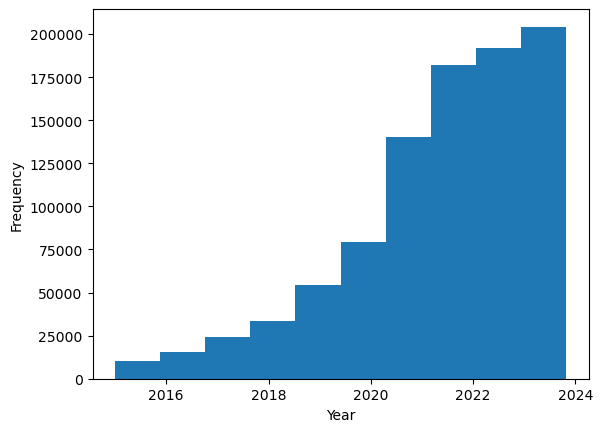

In [51]:
plt.hist(2015 + df["day"] * 1000 / 365)
plt.xlabel("Year")
plt.ylabel("Frequency")

Get the mean latitude per species.  Individuals within a species vary in terms of their locations.  We will use the mean latitude as a measure of the central latitude value for each species.

In [52]:
meanLat = df.groupby("species")["decimalLatitude"].aggregate(np.mean)
meanLat = meanLat.rename("meanLatitude")

The intraclass correlation (ICC) is a measure of how much the latitudes of species centroids vary in relation to how much the latitudes of individual plants vary. 

In [53]:
df = pd.merge(df, meanLat, on="species")
icc = df["meanLatitude"].var() / df["decimalLatitude"].var()
print(icc)

0.9073153359434151


Treat longitude as a circular variable

In [54]:
df["lonrad"] = np.pi * df["decimalLongitude"] / 180
df["lonrad_sin"] = np.sin(df["lonrad"])
df["lonrad_cos"] = np.cos(df["lonrad"])

Create a variable that cannot contain any unique information about the outcome.  This is used to assess the validity of the analyses conducted below.

In [55]:
df["fake"] = df["lonrad_cos"] + np.random.normal(size=df.shape[0])

Below we fit a linear model predicting latitude from day and other variables, using OLS, for each species.  The main interest here is the relationship between "day" and the mean latitude.  If this coefficient is positive for a given species, this species is identified at more northernly locations as time progresses.  If the coefficient is negative the species is identified at more southernly locations as time progresses.  We assess these effects using two models.  The first model has only main effects and the second model allows the time trend in mean latitude to vary by longitude.

In [ ]:
rr = []
for (sp,dx) in df.groupby("species"):

    if dx.shape[0] < 10:
        continue

    md1 = sm.OLS.from_formula("decimalLatitude ~ day + lonrad_sin + lonrad_cos + fake", data=dx)
    mr1 = md1.fit()

    md2 = sm.OLS.from_formula("decimalLatitude ~ day * (lonrad_sin + lonrad_cos + fake)", data=dx)
    mr2 = md2.fit()

    # The likelihood ratio test statistic and its degrees of freedom.
    lrt = 2 * (mr2.llf - mr1.llf)
    dof = mr2.df_model - mr1.df_model

    # Apply a normalizing transformation to the LRT statistics.
    # This is called the Wilson-Hilferty transformation.
    if dof == 3 and np.linalg.svd(md1.exog,0)[1].min() > 1e-5:
        lrt_z = (lrt / dof)**(1/3)
        lrt_z -= 1 - 2/(9*dof)
        lrt_z /= np.sqrt(2/(9*dof))
    else:
        lrt_z = 0

    rr.append([sp, dx.shape[0], mr1.params["day"], mr1.bse["day"], mr1.params["fake"], mr1.bse["fake"], lrt_z])
 
rr = pd.DataFrame(rr, columns=["species", "n", "day_slope", "day_slope_se", "fake_slope", "fake_slope_se", "lrt_z"])
rr = rr.loc[rr["day_slope_se"] > 0]
rr.head()

/sw/pkgs/arc/python3.10-anaconda/2023.03/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Construct T-scores for parameters of interest. For species with large sample sizes these should be approximate Z-scores (they follow a standard normal distribution under the null hypothesis that the day slope is zero).  For smaller sample sizes we need to account for the uncertainty in the scale parameter estimate. 

In [ ]:
rr["day_slope_t"] = rr["day_slope"] / rr["day_slope_se"]
rr["fake_slope_t"] = rr["fake_slope"] / rr["fake_slope_se"]
rr.head()

In [ ]:
rr = pd.merge(rr, meanLat, left_on="species", right_index=True)
rr.head()

Account for finite group sizes, by mapping the t-distributed statistics to normally distributed statistics.

In [ ]:
def t_adjust(rr, vn, dof=5):
    x = tdist.cdf(rr[vn], rr["n"] - dof)
    x = np.clip(x, 1e-12, 1-1e-12)
    return norm.ppf(x)

rr["day_slope_z"] = t_adjust(rr, "day_slope_t")
rr["fake_slope_z"] = t_adjust(rr, "fake_slope_t")

The plot below illustrates the conversion from t-scores to z-scores.

In [ ]:
plt.clf()
plt.grid(True)
plt.plot(rr["day_slope_t"], rr["day_slope_z"], "o", alpha=0.2)
plt.xlabel("T-statistic", size=15)
plt.ylabel("Z-statistic", size=15)

In [ ]:
plt.hist(rr["day_slope_z"], bins=20, density=True)
x = np.linspace(-4, 4, 100)
y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
plt.plot(x, y, color="orange")
plt.xlabel("Day slope (Z-score)")
plt.ylabel("Standard normal density")

Below we have a quantile-quantile plot comparing the Z-scores observed for the data to the reference Z-scores.  

When analyzing the "polypodiopsida" (fern) class, we see that the observed Z-scores are substantially inflated relative to the reference Z-scores, suggesting that many of the day slope parameters are substantially different from zero.  The z-scores for the "fake" variable are almost perfectly standard normal, as expected.  The third plot below shows the normalized likelihood ratio test statistic comparing the base model with additive day and longitude effects to the model with day and longitude interactions.

In [ ]:
n = rr.shape[0]
xx = np.linspace(1/n, 1-1/n, n)
yy = norm.ppf(xx)
for vn in ["day_slope", "fake_slope", "lrt"]:
    zs = np.sort(rr["%s_z" % vn])
    plt.clf()
    plt.grid(True)
    plt.plot(zs, yy, "-")
    ii = np.ceil(np.linspace(0.1, 0.9, 9) * len(yy)).astype(int)
    plt.plot(zs[ii], yy[ii], "o", color="red")
    plt.axline((0, 0), slope=1, color="grey")
    plt.xlabel("Observed %s quantiles" % vn, size=15)
    plt.ylabel("Standard normal quantiles", size=15)
    plt.show()

To control family-wise error rates at 0.05 using the Bonferroni approach, the Z-scores must exceed this value in magnitude.

In [ ]:
n = rr["day_slope_z"].dropna().size
bonf_z = norm.ppf(1 - 0.025 / n)
np.sum(np.abs(rr["day_slope_z"]) > bonf_z)
print(n)
print(bonf_z)

z = np.abs(rr["day_slope_z"].dropna())
z = np.sort(z)[::-1]
plt.clf()
plt.grid(True)
plt.plot(z)
plt.axhline(bonf_z, color="purple")
plt.xlabel("Number of species")
plt.ylabel("Z-score")

We can count the number of species that would be deemed statistically significant using the Bonferroni approach to control the FWER at 0.05.

In [ ]:
(z > bonf_z).sum()

Calculate the local False Discovery Rate (local FDR).

In [ ]:
rr["locfdr"] = local_fdr(rr["day_slope_z"])
lfdr = np.sort(rr["locfdr"])
lfdr = lfdr[lfdr < 1]

plt.clf()
plt.grid(True)
plt.plot(lfdr)
plt.xlabel("Number of species")
plt.ylabel("local FDR")

We can count the number of species that would be deemed significant if we aim to control the false discovery rate to 0.1.

In [ ]:
(rr["locfdr"] <= 0.1).sum()

Plot the day slope Z-score against the mean latitude, to assess whether there are systematic trends in the Z-scores relative to distance from the equator.  The orange curves are empirical estimates of the 10th and 90th percentiles of the Z-scores at each fixed latitude.  The purple lines are the corresponding reference values under the null hypothesis.  

When analyzing the data for "polypodiopsida" (ferns), this plot reveals several points of interest.  There is an excess of large Z-scores at every latitude, suggesting that plants are changing their distributions (in latitude terms), and this is happening at all latidues.  Second, there is a symmetry between large positive and large negative Z-scores, suggesting that plants are as likely to move toward the poles as they are to move toward the equator.  Third, there may be slightly stronger evidence for changes in the northern part of the northern hemisphere compared to other regions.

In [ ]:
alpha = 0.05

rr = rr.sort_values(by="meanLatitude")    
plt.clf()
plt.grid(True)
plt.plot(rr["meanLatitude"], rr["day_slope_z"], "o", alpha=0.5)
y1 = rr["day_slope_z"].rolling(200).quantile(1 - alpha)
y2 = rr["day_slope_z"].rolling(200).quantile(alpha)
plt.plot(rr["meanLatitude"], y1, color="orange")
plt.plot(rr["meanLatitude"], y2, color="orange")
z = norm.ppf(1 - alpha)
plt.axhline(z, color="purple")
plt.axhline(-z, color="purple")
plt.xlabel("Mean latitude", size=15)
plt.ylabel("Day slope (Z)", size=15)
plt.show()

Next we plot the local FDR against the day slope Z-score.  This plot shows that small FDRs (<0.1) are obtained for Z-scores exceeding 3 in magnitude.

In [ ]:
plt.clf()
plt.grid(True)
plt.plot(rr["day_slope_z"], rr["locfdr"], "o", alpha=0.5)
plt.xlabel("Day slope (Z)", size=15)
plt.ylabel("Local FDR", size=15)

Next we plot the day slope Z-score against the sample size.  If we are mainly limited by power then the larger Z-scores will be concentrated where the sample size is larger.  This plot makes it clear that there are some Z-scores falling far outside the likely range for a standard normal variable, and these values can be either positive or negative.  Most of the largest Z-scores (in magnitude) occur with the larger sample sizes.

In [ ]:
rr = rr.sort_values(by="n")
rr["logn"] = np.log10(rr["n"])
plt.clf()
plt.grid(True)
plt.plot(rr["logn"], rr["day_slope_z"], "o", alpha=0.5)
y1 = rr["day_slope_z"].rolling(200).quantile(0.05)
y2 = rr["day_slope_z"].rolling(200).quantile(0.95)
plt.plot(rr["logn"], y1, color="orange")
plt.plot(rr["logn"], y2, color="orange")
z = norm.ppf(0.95)
plt.axhline(z, color="purple")
plt.axhline(-z, color="purple")
plt.xlabel("Log10 n", size=15)
plt.ylabel("Day slope (Z)", size=15)

We can also smooth the absolute Z-scores against log sample size.  Under the null hypothesis the Z-scores follow a standard normal distribution, and the expectation of the absolute value of a standard normal variate is $\sqrt{2/\pi}$, which is plotted below as the purple line.  It appears that there is some overdispersion of the Z-scores for the smaller sample sizes, but the extent of overdispersion (evidence for a relationship between mean latitude and time) is primarily present for the species with more than around $\exp(6) \approx 400$ observations.

In [ ]:
plt.clf()
plt.grid(True)
x = np.log(rr["n"])
y = np.abs(rr["day_slope_z"])
plt.plot(x, y, "o", alpha=0.5)
xy = lowess(y, x)
plt.plot(xy[:, 0], xy[:, 1], "-", color="orange")
plt.axhline(np.sqrt(2/np.pi), color="purple")
plt.xlabel("Log n", size=15)
plt.ylabel("Absolute day slope (|Z|)", size=15)